In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd /content/drive/MyDrive/Colab Notebooks/인사교_머신러닝/DL (딥러닝)

/content/drive/MyDrive/Colab Notebooks/인사교_머신러닝/DL (딥러닝)


### 목표 : 자동차 파손에 대한 감지
- Detection으로만 수행(단순한 객체 탐지)보다는 Segmentation이 각 픽셀 수준에서 객체 경계나 영역을 더 세밀하게 탐지

In [3]:
!pip install ultralytics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.9/41.9 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 871.9/871.9 kB 47.0 MB/s eta 0:00:00


In [4]:
from ultralytics import YOLO

In [5]:
# 세그먼트 맛보기

# 모델 불러오기
model = YOLO("yolov8n-seg.pt")

In [6]:
# 예측 수행
results = model.predict("https://ultralytics.com/images/bus.jpg", save = True, conf = 0.15)


Found https://ultralytics.com/images/bus.jpg locally at bus.jpg
image 1/1 /content/drive/MyDrive/Colab Notebooks/인사교_머신러닝/DL (딥러닝)/bus.jpg: 640x480 4 persons, 1 bus, 1 umbrella, 1 skateboard, 82.2ms
Speed: 14.3ms preprocess, 82.2ms inference, 1536.2ms postprocess per image at shape (1, 3, 640, 480)
Results saved to runs/segment/predict2


In [7]:
# 탐지한 객체 정보 확인
results[0].boxes

ultralytics.engine.results.Boxes object with attributes:

cls: tensor([ 0.,  0.,  0.,  5.,  0., 36., 25.], device='cuda:0')
conf: tensor([0.8778, 0.8602, 0.8412, 0.8382, 0.4119, 0.3920, 0.1996], device='cuda:0')
data: tensor([[6.7023e+02, 3.8868e+02, 8.0951e+02, 8.7714e+02, 8.7779e-01, 0.0000e+00],
        [4.8478e+01, 3.9623e+02, 2.4237e+02, 9.0443e+02, 8.6022e-01, 0.0000e+00],
        [2.2250e+02, 4.0784e+02, 3.4416e+02, 8.6190e+02, 8.4123e-01, 0.0000e+00],
        [2.8835e+00, 2.2795e+02, 8.0049e+02, 7.2202e+02, 8.3817e-01, 5.0000e+00],
        [0.0000e+00, 5.5165e+02, 7.7754e+01, 8.7552e+02, 4.1194e-01, 0.0000e+00],
        [6.6899e+02, 8.2287e+02, 8.1000e+02, 8.8216e+02, 3.9195e-01, 3.6000e+01],
        [3.0801e-01, 2.5171e+02, 3.3463e+01, 3.2589e+02, 1.9960e-01, 2.5000e+01]], device='cuda:0')
id: None
is_track: False
orig_shape: (1080, 810)
shape: torch.Size([7, 6])
xywh: tensor([[739.8715, 632.9112, 139.2816, 488.4546],
        [145.4260, 650.3315, 193.8962, 508.2000],
        [

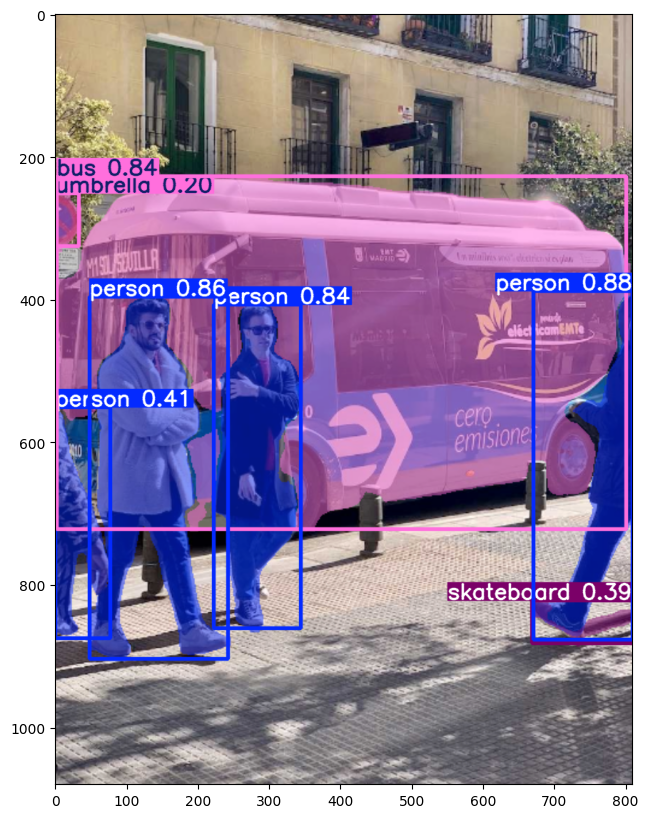

In [8]:
# 예측에 사용 된 이미지 출력
import matplotlib.pyplot as plt
import cv2
img = cv2.cvtColor(results[0].plot(), cv2.COLOR_BGR2RGB)

plt.figure(figsize=(10,10))
plt.imshow(img)
plt.show()

### Segmentation(세분화)와 Object Detection(객체 탐지)
- Segmentation이 보다 더 정밀한 기술 -> 픽셀단위로 객체의 경계를 추적함

> Object Detection : 대략적인 객체의 위치나 클래스만을 식별
Segmentation : 바운딩 박스뿐만 아니라, 객체의 모양까지 정확히 표현(객체의 영역을 세밀하게 인식)

- ex. 자동차 고장 영역만의 윤곽이나, 사람 눈(코, 입 등)의 실루엣을 픽셀 단위로 추적해서 복잡한 장면에서도 객체의 모양을 정확히 인식할 수 있음

In [9]:
# 차량 파손 데이터 다운
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="EZG1B0o5xoOIZOrl950O")
project = rf.workspace("none-n1imd").project("car-jxbzt")
version = project.version(1)
dataset = version.download("yolov8")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 3.1 MB/s eta 0:00:00
  Attempting uninstall: idna
    Found existing installation: idna 3.8
    Uninstalling idna-3.8:
      Successfully uninstalled idna-3.8
loading Roboflow workspace...
loading Roboflow project...
Dependency ultralytics==8.0.196 is required but found version=8.2.92, to fix: `pip install ultralytics==8.0.196`


In [10]:
# 새로운 seg 모델 만들고, 학습 정보(가중치)만 불러오기!
model = YOLO("yolov8n-seg.yaml").load("yolov8n.pt")

Transferred 355/417 items from pretrained weights


In [11]:
model.train(data = "./car-1/data.yaml", epochs = 100, imgsz = 640)

Ultralytics YOLOv8.2.92 🚀 Python-3.10.12 torch-2.4.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=segment, mode=train, model=yolov8n-seg.yaml, data=./car-1/data.yaml, epochs=100, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=yolov8n.pt, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, 

100%|██████████| 755k/755k [00:00<00:00, 117MB/s]


Overriding model.yaml nc=80 with nc=14

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytic

train: Scanning /content/drive/MyDrive/Colab Notebooks/인사교_머신러닝/DL (딥러닝)/car-1/train/labels... 312 images, 0 backgrounds, 0 corrupt: 100%|██████████| 312/312 [03:24<00:00,  1.52it/s]


train: New cache created: /content/drive/MyDrive/Colab Notebooks/인사교_머신러닝/DL (딥러닝)/car-1/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
val: Scanning /content/drive/MyDrive/Colab Notebooks/인사교_머신러닝/DL (딥러닝)/car-1/valid/labels... 19 images, 0 backgrounds, 0 corrupt: 100%|██████████| 19/19 [00:22<00:00,  1.20s/it]

val: New cache created: /content/drive/MyDrive/Colab Notebooks/인사교_머신러닝/DL (딥러닝)/car-1/valid/labels.cache


Plotting labels to runs/segment/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000556, momentum=0.9) with parameter groups 66 weight(decay=0.0), 77 weight(decay=0.0005), 76 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/segment/train
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      1/100      2.88G       1.69      6.749      4.606      1.858         36        640: 100%|██████████| 20/20 [00:14<00:00,  1.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.30s/it]

                   all         19         33     0.0104     0.0208     0.0142    0.00623     0.0104     0.0208     0.0142    0.00425



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      2/100       2.9G      1.467      5.199      4.406      1.699         39        640: 100%|██████████| 20/20 [00:07<00:00,  2.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.26it/s]

                   all         19         33    0.00322      0.247     0.0204    0.00766     0.0037      0.244     0.0105    0.00426



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      3/100      2.86G      1.445      4.841      3.999      1.613         44        640: 100%|██████████| 20/20 [00:10<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.89it/s]

                   all         19         33    0.00559      0.455      0.108     0.0302    0.00392      0.327     0.0545     0.0236



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      4/100      2.86G      1.429      4.559      3.701      1.547         28        640: 100%|██████████| 20/20 [00:07<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.46it/s]

                   all         19         33      0.995     0.0833      0.125     0.0316      0.995     0.0833      0.116     0.0232



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      5/100      2.86G      1.444       4.33      3.449      1.536         42        640: 100%|██████████| 20/20 [00:09<00:00,  2.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.87it/s]

                   all         19         33      0.631      0.125     0.0993     0.0367      0.809      0.104     0.0834     0.0262



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      6/100      2.82G      1.337      4.101      3.224      1.466         28        640: 100%|██████████| 20/20 [00:09<00:00,  2.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.01it/s]

                   all         19         33      0.767     0.0833     0.0747     0.0285      0.766     0.0833     0.0314     0.0052



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      7/100       2.9G      1.319      3.951      2.961      1.434         33        640: 100%|██████████| 20/20 [00:07<00:00,  2.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.01it/s]

                   all         19         33      0.663      0.206      0.202      0.108      0.638      0.153       0.16     0.0841



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      8/100      2.82G      1.284      3.747      2.881      1.421         39        640: 100%|██████████| 20/20 [00:10<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.42it/s]

                   all         19         33      0.783      0.111      0.149     0.0596      0.783      0.111      0.147      0.058



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      9/100      2.82G      1.257       3.55      2.789      1.392         23        640: 100%|██████████| 20/20 [00:07<00:00,  2.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.59it/s]

                   all         19         33      0.303      0.165     0.0989     0.0304      0.297      0.161     0.0594     0.0198



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     10/100      2.82G      1.227      3.429      2.625      1.358         27        640: 100%|██████████| 20/20 [00:09<00:00,  2.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.74it/s]

                   all         19         33      0.598      0.186      0.133     0.0538      0.571      0.153     0.0915     0.0238



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     11/100      2.84G      1.148      3.235      2.485       1.32         21        640: 100%|██████████| 20/20 [00:08<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.12it/s]

                   all         19         33      0.894     0.0833      0.212      0.106      0.894     0.0833      0.155     0.0686



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     12/100       2.8G      1.181      3.275      2.344      1.324         38        640: 100%|██████████| 20/20 [00:08<00:00,  2.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.87it/s]

                   all         19         33      0.558      0.137      0.173     0.0831      0.805      0.104      0.119     0.0459



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     13/100      2.79G      1.152      3.275      2.369      1.316         32        640: 100%|██████████| 20/20 [00:09<00:00,  2.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.39it/s]

                   all         19         33      0.508      0.222      0.186      0.111      0.509      0.222      0.185     0.0786



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     14/100      2.89G      1.108      3.096      2.195      1.295         29        640: 100%|██████████| 20/20 [00:07<00:00,  2.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.78it/s]

                   all         19         33      0.454      0.232      0.207      0.102      0.435      0.206      0.185     0.0663



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     15/100      2.84G      1.068      2.991      2.092       1.25         43        640: 100%|██████████| 20/20 [00:10<00:00,  2.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.06it/s]

                   all         19         33      0.509      0.257       0.22     0.0963      0.486      0.211      0.179     0.0615



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     16/100      2.93G      1.126      2.954      1.995      1.274         31        640: 100%|██████████| 20/20 [00:07<00:00,  2.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.96it/s]

                   all         19         33      0.314      0.186      0.197     0.0928      0.913     0.0927      0.142     0.0685



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     17/100      2.82G      1.065      2.877      1.916      1.245         24        640: 100%|██████████| 20/20 [00:09<00:00,  2.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.85it/s]

                   all         19         33      0.526      0.208      0.178     0.0763      0.686       0.16      0.143     0.0491



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     18/100      2.81G      1.069      2.804      1.918      1.246         22        640: 100%|██████████| 20/20 [00:09<00:00,  2.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.05it/s]

                   all         19         33      0.844      0.201      0.275      0.129      0.844      0.201      0.285      0.103



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     19/100      2.84G      1.023      2.763      1.804      1.195         24        640: 100%|██████████| 20/20 [00:10<00:00,  1.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.12it/s]

                   all         19         33      0.659      0.153      0.219      0.124      0.608      0.146      0.194       0.09



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     20/100      2.87G     0.9942      2.694      1.773      1.175         26        640: 100%|██████████| 20/20 [00:09<00:00,  2.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.01it/s]

                   all         19         33      0.449      0.281      0.282      0.183      0.428      0.174      0.219      0.101



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     21/100      2.84G     0.9966      2.611      1.727      1.191         22        640: 100%|██████████| 20/20 [00:07<00:00,  2.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.12it/s]

                   all         19         33      0.447      0.235      0.264       0.12       0.71      0.132      0.204     0.0835



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     22/100      2.84G     0.9763      2.562      1.671      1.184         43        640: 100%|██████████| 20/20 [00:08<00:00,  2.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.82it/s]

                   all         19         33      0.596      0.194      0.274      0.136      0.596      0.194      0.259     0.0827



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     23/100      2.85G     0.9448      2.493      1.641      1.162         20        640: 100%|██████████| 20/20 [00:09<00:00,  2.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.00s/it]

                   all         19         33      0.646      0.306      0.298      0.162      0.979      0.188      0.261     0.0984



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     24/100      2.95G     0.9571      2.425      1.561      1.162         33        640: 100%|██████████| 20/20 [00:07<00:00,  2.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.94it/s]

                   all         19         33      0.503      0.248      0.237      0.115      0.576      0.224      0.179     0.0705



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     25/100      2.86G      0.923       2.32       1.53       1.15         26        640: 100%|██████████| 20/20 [00:09<00:00,  2.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.96it/s]

                   all         19         33      0.462      0.274      0.293      0.156      0.444      0.249       0.25     0.0957



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     26/100      2.83G     0.9139      2.362      1.506      1.123         25        640: 100%|██████████| 20/20 [00:07<00:00,  2.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.84it/s]

                   all         19         33      0.535      0.215      0.286      0.117       0.42      0.194      0.215     0.0908



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     27/100      2.83G     0.9105      2.361      1.424      1.106         35        640: 100%|██████████| 20/20 [00:09<00:00,  2.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.01it/s]

                   all         19         33      0.432      0.246      0.197      0.108      0.444      0.189      0.133     0.0636



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     28/100      2.88G     0.8591      2.185      1.396      1.094         31        640: 100%|██████████| 20/20 [00:08<00:00,  2.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.19it/s]

                   all         19         33      0.397      0.174      0.226      0.148      0.387      0.132      0.191     0.0917



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     29/100      2.86G     0.8941      2.295      1.368      1.103         42        640: 100%|██████████| 20/20 [00:07<00:00,  2.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.82it/s]

                   all         19         33      0.623      0.333      0.266      0.146      0.574      0.243      0.187     0.0909



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     30/100      2.82G     0.8805      2.234      1.334      1.088         35        640: 100%|██████████| 20/20 [00:10<00:00,  1.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.09it/s]

                   all         19         33      0.428      0.316      0.344      0.148      0.356      0.229      0.259     0.0923



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     31/100      2.85G     0.8882      2.231       1.35      1.096         41        640: 100%|██████████| 20/20 [00:07<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.74it/s]

                   all         19         33      0.484      0.343      0.289      0.154      0.743       0.16      0.202     0.0949



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     32/100      2.88G     0.8749      2.076      1.285      1.081         27        640: 100%|██████████| 20/20 [00:10<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.95it/s]

                   all         19         33      0.637      0.371      0.392      0.174       0.54      0.257      0.253      0.127



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     33/100      2.86G     0.8133      2.092      1.283      1.078         27        640: 100%|██████████| 20/20 [00:07<00:00,  2.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.71it/s]

                   all         19         33      0.779      0.262      0.351      0.172      0.779      0.262      0.326       0.14



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     34/100      2.83G     0.8455      2.039      1.233      1.067         38        640: 100%|██████████| 20/20 [00:09<00:00,  2.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.97it/s]

                   all         19         33      0.803      0.194      0.291      0.151      0.731      0.153      0.222      0.115



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     35/100      2.85G     0.8722      2.106      1.269      1.099         26        640: 100%|██████████| 20/20 [00:08<00:00,  2.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.11it/s]

                   all         19         33      0.443      0.312      0.306      0.178      0.407      0.234      0.248      0.127



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     36/100      2.87G     0.7966       1.97       1.19      1.055         17        640: 100%|██████████| 20/20 [00:07<00:00,  2.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.75it/s]

                   all         19         33       0.37      0.215      0.246      0.147      0.399      0.194      0.224      0.122



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     37/100      2.82G     0.8306      2.012      1.189      1.066         39        640: 100%|██████████| 20/20 [00:10<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.50it/s]

                   all         19         33       0.36      0.198      0.177     0.0869      0.347      0.174       0.15     0.0608



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     38/100      2.88G     0.8373      1.949      1.245      1.077         26        640: 100%|██████████| 20/20 [00:07<00:00,  2.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.40it/s]

                   all         19         33      0.548      0.254      0.276      0.132      0.495      0.212      0.211     0.0906



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     39/100       2.9G     0.7944      1.969      1.131       1.04         29        640: 100%|██████████| 20/20 [00:10<00:00,  1.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.05it/s]

                   all         19         33      0.466      0.287      0.253      0.136      0.452      0.255      0.203     0.0897



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     40/100      2.86G     0.7637      1.829       1.09      1.024         32        640: 100%|██████████| 20/20 [00:07<00:00,  2.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.30it/s]

                   all         19         33      0.487      0.296      0.271      0.148       0.43      0.264       0.21      0.109



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     41/100      2.94G     0.7956      1.837      1.172       1.04         38        640: 100%|██████████| 20/20 [00:08<00:00,  2.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.80it/s]

                   all         19         33      0.831      0.255      0.296      0.148      0.808      0.243      0.247      0.091



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     42/100      2.82G      0.771      1.797      1.114      1.015         27        640: 100%|██████████| 20/20 [00:09<00:00,  2.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.82it/s]

                   all         19         33      0.886      0.255      0.293      0.152      0.898      0.222      0.212      0.094



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     43/100      2.86G     0.7274      1.769      1.075      1.012         15        640: 100%|██████████| 20/20 [00:10<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.99it/s]

                   all         19         33      0.519      0.255      0.307      0.176      0.785      0.243      0.263        0.1



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     44/100      2.88G     0.7519      1.797      1.063      1.041         24        640: 100%|██████████| 20/20 [00:09<00:00,  2.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.04it/s]

                   all         19         33      0.908      0.235      0.298      0.161      0.802      0.238       0.24     0.0885



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     45/100       2.8G     0.7625      1.714       1.08      1.033         23        640: 100%|██████████| 20/20 [00:07<00:00,  2.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.83it/s]

                   all         19         33      0.663      0.315      0.332      0.167      0.619      0.262      0.278      0.102



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     46/100       2.9G      0.722       1.74     0.9979      1.006         29        640: 100%|██████████| 20/20 [00:09<00:00,  2.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.12it/s]

                   all         19         33      0.429       0.29      0.324      0.162       0.39      0.227      0.263     0.0949



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     47/100      2.84G     0.7464      1.776      1.046      1.013         29        640: 100%|██████████| 20/20 [00:09<00:00,  2.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.05it/s]

                   all         19         33      0.334       0.26      0.267      0.111      0.947      0.159      0.214     0.0768



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     48/100      2.84G     0.7276      1.708      1.019       1.01         43        640: 100%|██████████| 20/20 [00:07<00:00,  2.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.93it/s]

                   all         19         33      0.674      0.297      0.311       0.14       0.59      0.227      0.264     0.0644



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     49/100      2.84G     0.7226      1.713      1.023      1.018         23        640: 100%|██████████| 20/20 [00:10<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.22it/s]

                   all         19         33      0.828      0.174      0.244     0.0983      0.828      0.174       0.19     0.0407



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     50/100      2.84G     0.6973      1.589     0.9804      1.008         15        640: 100%|██████████| 20/20 [00:07<00:00,  2.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.69it/s]

                   all         19         33      0.852      0.173      0.276      0.156      0.852      0.173      0.251     0.0879



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     51/100      2.81G     0.6877      1.595     0.9693     0.9854         34        640: 100%|██████████| 20/20 [00:09<00:00,  2.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.77it/s]

                   all         19         33      0.699      0.213      0.258      0.149      0.699      0.213      0.252      0.108



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     52/100      2.82G     0.7078      1.638      0.961      1.002         35        640: 100%|██████████| 20/20 [00:08<00:00,  2.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.18it/s]

                   all         19         33      0.758      0.206      0.258      0.157      0.758      0.206      0.228     0.0878



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     53/100      2.86G     0.7051      1.611     0.9348     0.9935         23        640: 100%|██████████| 20/20 [00:08<00:00,  2.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.93it/s]

                   all         19         33      0.703      0.218      0.266      0.126      0.703      0.218      0.233     0.0856



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     54/100      2.89G     0.6791      1.593     0.9324      0.989         39        640: 100%|██████████| 20/20 [00:09<00:00,  2.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.26it/s]

                   all         19         33      0.493      0.218      0.255      0.103      0.496      0.218      0.197     0.0637



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     55/100      2.86G     0.6572      1.496     0.8842     0.9761         23        640: 100%|██████████| 20/20 [00:06<00:00,  2.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.82it/s]

                   all         19         33      0.644      0.225      0.279      0.114      0.637      0.197      0.219     0.0586



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     56/100      2.84G     0.6449      1.502     0.8928     0.9815         19        640: 100%|██████████| 20/20 [00:10<00:00,  1.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.44it/s]

                   all         19         33      0.324      0.286       0.29       0.13      0.699      0.194      0.234     0.0671



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     57/100      2.77G     0.6706      1.505     0.8946     0.9875         47        640: 100%|██████████| 20/20 [00:07<00:00,  2.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.63it/s]

                   all         19         33      0.607      0.276      0.282      0.135      0.533      0.221      0.235     0.0909



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     58/100      2.88G     0.6693       1.52     0.9108     0.9919         25        640: 100%|██████████| 20/20 [00:09<00:00,  2.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.45it/s]

                   all         19         33      0.593      0.281      0.299      0.144      0.569      0.274      0.259      0.086



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     59/100      2.84G     0.6919      1.595      0.927     0.9991         27        640: 100%|██████████| 20/20 [00:08<00:00,  2.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.02it/s]

                   all         19         33      0.486      0.317      0.366      0.192       0.42      0.239      0.258      0.101



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     60/100      2.82G     0.6587      1.497     0.8682     0.9851         27        640: 100%|██████████| 20/20 [00:07<00:00,  2.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.31it/s]

                   all         19         33       0.72      0.253      0.299      0.156      0.649       0.22      0.232      0.112



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     61/100      2.85G     0.6692      1.563     0.8873     0.9918         35        640: 100%|██████████| 20/20 [00:10<00:00,  1.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.79it/s]

                   all         19         33      0.628      0.267      0.331      0.186      0.628      0.248      0.268      0.112



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     62/100      2.89G     0.6526      1.507     0.8689     0.9742         28        640: 100%|██████████| 20/20 [00:07<00:00,  2.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.41it/s]

                   all         19         33      0.457      0.309      0.355      0.194      0.429      0.311      0.339      0.129



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     63/100      2.88G     0.6559       1.47     0.8568     0.9686         28        640: 100%|██████████| 20/20 [00:10<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.92it/s]

                   all         19         33      0.822      0.196       0.33      0.186      0.822      0.196      0.298      0.135



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     64/100       2.9G     0.6461      1.431      0.829     0.9666         38        640: 100%|██████████| 20/20 [00:07<00:00,  2.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.28it/s]

                   all         19         33       0.69      0.266      0.361      0.184      0.356      0.246      0.301      0.116



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     65/100       2.8G     0.6579      1.415     0.8267     0.9751         28        640: 100%|██████████| 20/20 [00:09<00:00,  2.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.99it/s]

                   all         19         33      0.729      0.257      0.335      0.161      0.757       0.21      0.298      0.127



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     66/100      2.94G     0.6471      1.418      0.821     0.9633         23        640: 100%|██████████| 20/20 [00:12<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.11it/s]

                   all         19         33      0.724      0.261      0.349      0.166      0.711      0.249      0.317      0.123



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     67/100      2.79G     0.6536       1.48      0.822     0.9823         34        640: 100%|██████████| 20/20 [00:07<00:00,  2.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.96it/s]

                   all         19         33       0.74      0.296      0.317      0.164      0.697      0.255      0.277      0.125



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     68/100      2.86G     0.6213      1.422     0.8094     0.9495         42        640: 100%|██████████| 20/20 [00:09<00:00,  2.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.76it/s]

                   all         19         33      0.794      0.281      0.338      0.152       0.62      0.283      0.371     0.0967



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     69/100      2.82G     0.6219      1.374     0.8011     0.9567         31        640: 100%|██████████| 20/20 [00:07<00:00,  2.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.24it/s]

                   all         19         33      0.424      0.329      0.367      0.166      0.608       0.31      0.362     0.0846



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     70/100      2.93G     0.6013      1.398     0.7799     0.9558         34        640: 100%|██████████| 20/20 [00:08<00:00,  2.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.75it/s]

                   all         19         33      0.491      0.302      0.351      0.159      0.474       0.29      0.342      0.102



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     71/100      2.86G     0.6121      1.385     0.7984      0.963         33        640: 100%|██████████| 20/20 [00:09<00:00,  2.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.24it/s]

                   all         19         33      0.561      0.322      0.308      0.176      0.692      0.264      0.263     0.0933



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     72/100      2.84G     0.5884      1.318     0.7708     0.9441         31        640: 100%|██████████| 20/20 [00:07<00:00,  2.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.92it/s]

                   all         19         33      0.546      0.264       0.37       0.19      0.823      0.215      0.258      0.111



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     73/100       2.8G     0.5677       1.32     0.7667     0.9452         16        640: 100%|██████████| 20/20 [00:10<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.82it/s]

                   all         19         33      0.841      0.215      0.324      0.182      0.841      0.215       0.26      0.108



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     74/100      2.84G      0.617      1.359     0.7651     0.9488         37        640: 100%|██████████| 20/20 [00:07<00:00,  2.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.94it/s]

                   all         19         33      0.527      0.278      0.356      0.187      0.477      0.248      0.279      0.104



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     75/100      2.87G     0.5886      1.323     0.7533     0.9523         29        640: 100%|██████████| 20/20 [00:10<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.89it/s]

                   all         19         33      0.655        0.3      0.328      0.165       0.58      0.254      0.248     0.0774



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     76/100      2.89G     0.5946      1.352     0.7729     0.9671         29        640: 100%|██████████| 20/20 [00:07<00:00,  2.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.53it/s]

                   all         19         33        0.6      0.282      0.334      0.155      0.585      0.255      0.279     0.0856



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     77/100      2.84G     0.5872      1.342      0.745     0.9447         34        640: 100%|██████████| 20/20 [00:09<00:00,  2.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.87it/s]

                   all         19         33      0.818      0.255      0.373      0.168      0.798      0.227      0.309      0.101



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     78/100      2.89G     0.5933      1.288     0.7388     0.9419         19        640: 100%|██████████| 20/20 [00:08<00:00,  2.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.00it/s]

                   all         19         33      0.744      0.344      0.431      0.199      0.803      0.227      0.279      0.115



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     79/100      2.82G     0.5918      1.309     0.7641     0.9708         26        640: 100%|██████████| 20/20 [00:08<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.43it/s]

                   all         19         33      0.572      0.308      0.393       0.19       0.87      0.215      0.271       0.11



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     80/100      2.81G     0.5789      1.321     0.7777     0.9576         27        640: 100%|██████████| 20/20 [00:09<00:00,  2.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.82it/s]

                   all         19         33      0.646      0.317       0.38      0.192      0.814       0.25      0.289      0.114



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     81/100      2.85G     0.5624      1.256     0.7346     0.9269         24        640: 100%|██████████| 20/20 [00:07<00:00,  2.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.30it/s]

                   all         19         33      0.585      0.347      0.335      0.176      0.702      0.264      0.251     0.0938



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     82/100      2.81G     0.5813      1.312     0.7223      0.935         31        640: 100%|██████████| 20/20 [00:09<00:00,  2.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.22it/s]

                   all         19         33      0.627      0.355      0.353      0.188      0.764      0.269        0.3      0.102



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     83/100      2.84G     0.5576      1.278     0.7336     0.9419         34        640: 100%|██████████| 20/20 [00:07<00:00,  2.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.56it/s]

                   all         19         33      0.609      0.352      0.395      0.207      0.785      0.269      0.343      0.135



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     84/100      2.86G     0.5659      1.254     0.7146     0.9408         20        640: 100%|██████████| 20/20 [00:08<00:00,  2.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.07it/s]

                   all         19         33      0.714      0.311      0.417      0.176      0.811      0.257      0.326      0.133



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     85/100      2.82G     0.5722      1.272      0.734     0.9527         28        640: 100%|██████████| 20/20 [00:09<00:00,  2.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.56it/s]

                   all         19         33      0.583      0.322       0.39      0.177      0.781      0.269      0.325      0.122



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     86/100      2.84G     0.5308      1.244     0.7014     0.9364         35        640: 100%|██████████| 20/20 [00:07<00:00,  2.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.35it/s]

                   all         19         33      0.608      0.294      0.339       0.17      0.797      0.226      0.235     0.0912



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     87/100      2.84G      0.569      1.268     0.7026     0.9446         29        640: 100%|██████████| 20/20 [00:10<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.05it/s]

                   all         19         33      0.505      0.318      0.306      0.149      0.462      0.248      0.228     0.0905



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     88/100      2.84G     0.5569      1.272      0.701     0.9377         24        640: 100%|██████████| 20/20 [00:07<00:00,  2.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.70it/s]

                   all         19         33      0.331      0.311      0.297      0.154      0.765      0.221       0.22     0.0881



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     89/100       2.8G     0.5238      1.247     0.6999     0.9295         27        640: 100%|██████████| 20/20 [00:12<00:00,  1.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.81it/s]

                   all         19         33       0.32       0.29      0.309      0.152      0.277      0.269      0.238     0.0873



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     90/100       2.8G      0.542      1.236     0.6851     0.9296         39        640: 100%|██████████| 20/20 [00:08<00:00,  2.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.05s/it]

                   all         19         33      0.489      0.315      0.378       0.18      0.514      0.264      0.299      0.113


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     91/100      2.76G     0.4568      1.042     0.6676       0.89         19        640: 100%|██████████| 20/20 [00:10<00:00,  1.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.45it/s]

                   all         19         33      0.436      0.277      0.335      0.161      0.398      0.256      0.287      0.109



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     92/100      2.76G     0.4464      1.017     0.6527     0.8879         18        640: 100%|██████████| 20/20 [00:09<00:00,  2.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.35it/s]

                   all         19         33      0.593      0.265      0.316      0.167      0.717      0.215      0.256      0.105



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     93/100      2.76G     0.4441     0.9938     0.6493     0.8924         18        640: 100%|██████████| 20/20 [00:07<00:00,  2.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.11it/s]

                   all         19         33      0.593      0.281      0.315      0.178      0.607      0.244      0.282      0.111



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     94/100      2.76G     0.4507     0.9843     0.6438     0.9112         17        640: 100%|██████████| 20/20 [00:08<00:00,  2.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.59it/s]

                   all         19         33      0.571      0.281      0.341      0.196      0.816      0.215      0.257       0.11



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     95/100      2.76G     0.4413     0.9974     0.6357     0.8774         17        640: 100%|██████████| 20/20 [00:07<00:00,  2.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.25it/s]

                   all         19         33      0.589      0.281      0.344      0.184      0.622      0.264      0.285      0.114



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     96/100      2.76G     0.4359     0.9609     0.6323     0.8944         15        640: 100%|██████████| 20/20 [00:07<00:00,  2.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.37it/s]

                   all         19         33      0.622      0.273      0.339      0.181       0.63      0.267      0.283      0.117



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     97/100      2.74G     0.4177     0.9674     0.6293     0.8699         12        640: 100%|██████████| 20/20 [00:08<00:00,  2.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.07it/s]

                   all         19         33        0.6      0.281      0.341      0.189      0.623      0.268      0.291      0.121



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     98/100      2.76G       0.41     0.9549      0.622     0.8744         16        640: 100%|██████████| 20/20 [00:06<00:00,  2.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.07it/s]

                   all         19         33      0.619      0.268      0.337      0.196      0.619      0.268      0.301      0.119



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     99/100      2.78G     0.4063     0.9219     0.6058     0.8736         18        640: 100%|██████████| 20/20 [00:09<00:00,  2.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.13it/s]

                   all         19         33      0.614      0.267      0.332      0.194      0.614      0.267      0.299      0.118



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    100/100      2.76G     0.4233     0.9553     0.6137     0.8852         15        640: 100%|██████████| 20/20 [00:06<00:00,  3.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.66it/s]

                   all         19         33      0.601      0.265      0.334      0.195      0.601      0.265      0.281      0.114



100 epochs completed in 0.300 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 6.8MB
Optimizer stripped from runs/segment/train/weights/best.pt, 6.8MB

Validating runs/segment/train/weights/best.pt...
Ultralytics YOLOv8.2.92 🚀 Python-3.10.12 torch-2.4.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
YOLOv8n-seg summary (fused): 195 layers, 3,260,794 parameters, 0 gradients, 12.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.68it/s]


                   all         19         33      0.612      0.354      0.396      0.207      0.785      0.269      0.343      0.135
           door_damage          2          2          1          0          0          0          1          0     0.0177    0.00177
         fender_damage          2          2          1      0.985      0.995      0.359      0.908        0.5      0.499      0.249
   front_bumper_damage          7          7      0.545      0.182      0.259       0.16      0.781      0.143      0.148     0.0591
          glass_damage          1          1      0.366          1      0.995      0.597      0.474          1      0.995      0.597
          grill_damage          1          1          0          0          0          0          0          0          0          0
           hood_damage          3          3      0.155      0.333      0.345      0.204      0.358      0.333      0.389      0.209
     rear_bumper_damag          2          2      0.808        0.5   

ultralytics.utils.metrics.SegmentMetrics object with attributes:

ap_class_index: array([ 0,  1,  2,  4,  5,  6,  7,  8,  9, 10, 11, 13])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x78ea3a7895a0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)', 'Precision-Recall(M)', 'F1-Confidence(M)', 'Precision-Confidence(M)', 'Recall-Confidence(M)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.03

In [12]:
# 모델 불러오기
best_path = "/content/drive/MyDrive/Colab Notebooks/인사교_머신러닝/DL (딥러닝)/runs/segment/train/weights/best.pt"

best_model = YOLO(best_path)

In [14]:
# 예측하기

# 예측에 사용될 이미지 소스 하나 가져옴
source = "/content/drive/MyDrive/Colab Notebooks/인사교_머신러닝/DL (딥러닝)/car-1/valid/images/Broken_car_front_bumper_jpg.rf.eed2a61e985862ba31f3bf8f7ee6cd86.jpg"

# 저장할 때 원하는 디렉토리 지정
save_dir = "/content/drive/MyDrive/Colab Notebooks/인사교_머신러닝/DL (딥러닝)/runs/segment/predict"

results = best_model(source = source, show = True, save = True, save_dir = save_dir, conf = 0.1)

WARNING ⚠️ Environment does not support cv2.imshow() or PIL Image.show()


image 1/1 /content/drive/MyDrive/Colab Notebooks/인사교_머신러닝/DL (딥러닝)/car-1/valid/images/Broken_car_front_bumper_jpg.rf.eed2a61e985862ba31f3bf8f7ee6cd86.jpg: 640x640 1 hood_damage, 17.2ms
Speed: 2.6ms preprocess, 17.2ms inference, 4.8ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs/segment/predict3
